In [63]:
import pandas as pd
import numpy as np
from scipy import stats
from collections import Counter
from evaluate import f1score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [64]:
#
# Read in and down-select training data
# 

print "Reading and merging orders tables ... ",

train = pd.read_csv('order_products__train.csv')
prior = pd.read_csv('order_products__prior.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')

# sample just a subset of training set for speed
N = 15000
oids = train['order_id'].unique()[:N]
train = train[train['order_id'].isin(oids)]
train = train.merge(
    orders, on='order_id', how='left').merge(
    products, on='product_id', how='left')

# take only prior data corresponding to users left in training set
uids = train['user_id'].unique()
prior = prior.merge(orders, on='order_id', how='left')
prior = prior[prior['user_id'].isin(uids)]
prior = prior.merge(products, on='product_id', how='left')

print "done."

Reading and merging orders tables ...  done.


In [65]:
# Generate np array of features ...
#
# Taking motivation from this kernel:
# https://www.kaggle.com/fabienvs/instacart-xgboost-starter-lb-0-3791/code
# We will use as features:
#
#   1: Number of times product has been ordered by user
user_prod_norders = prior.groupby(['user_id', 'product_id']
    ).apply(len).reset_index(name='user_prod_norders')

#   2: Total number of orders by user
user_norders = prior.groupby('user_id'
    ).apply(lambda x: len(set(x['order_id']))).reset_index(name='user_norders')

#   3: Number of baskets since user last ordered this item
baskets_since = prior.groupby(['user_id', 'product_id']
    ).apply(lambda x: max(x['order_number'])
    ).reset_index(name='last_basket')

baskets_since = baskets_since.merge(user_norders, on='user_id', how='left')
baskets_since['basktets_since'] = baskets_since['user_norders'] - baskets_since['last_basket']
del baskets_since['user_norders'], baskets_since['last_basket']

#   4: Number of times product has been ordered / number of users that
#      that have ordered the product
reorder_rate = prior.groupby('product_id').apply(
    lambda x: float(len(x)) / float(len(set(x['user_id'])))
    ).reset_index(name='reorder_rate')

training_data = user_prod_norders.merge(
    user_norders, on='user_id', how='left'
    ).merge(baskets_since, on=['user_id', 'product_id'], how='left'
    ).merge(reorder_rate, on='product_id', how='left')

# Add training data, i.e., whether product was reordered by user
training_data = training_data.merge(
    train[['user_id','product_id','reordered']], on=['user_id','product_id'], how='left').fillna(0)

training_data.head(15)

,user_id,product_id,user_prod_norders,user_norders,basktets_since,reorder_rate,reordered
0,30,6184,1,8,2,4.181989,0.0
1,30,21386,5,8,3,3.537118,0.0
2,30,23288,1,8,0,3.469841,1.0
3,30,27839,1,8,7,2.621622,0.0
4,30,38300,2,8,0,1.530864,0.0
5,30,45128,1,8,7,2.428571,0.0
6,55,1244,1,7,1,2.377907,0.0
7,55,1866,1,7,3,1.000000,0.0
8,55,4658,7,7,0,4.500000,1.0
9,55,5194,2,7,0,2.509235,0.0


In [66]:
# input / target
X = training_data[['user_prod_norders','user_norders','basktets_since','reorder_rate']].as_matrix()
y = training_data['reordered'].as_matrix()

clf = DecisionTreeClassifier(random_state=0, min_samples_split=10000, max_depth=10)
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=10000, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [67]:
pred = clf.predict_proba(X)[:, 1]
target = train.groupby('user_id'
    ).apply(lambda x: set(x[x['reordered'] == True]['product_id'])
    ).reset_index(name='target')

for p in np.linspace(0.01, 0.3, 15):
    training_data['prediction'] = pred > p
    out = training_data.groupby('user_id').apply(
        lambda x: set(x[x['prediction'] == True]['product_id'])
        ).reset_index(name='prediction')

    out = out.merge(target, on='user_id', how='left')
    print p, f1score(out['prediction'], out['target'])

0.01 0.221563579628
0.0307142857143 0.254582423352
0.0514285714286 0.286531910851
0.0721428571429 0.312779786851
0.0928571428571 0.336394480036
0.113571428571 0.347578474577
0.134285714286 0.35825182339
0.155 0.365147843599
0.175714285714 0.369586073998
0.196428571429 0.369923817279
0.217142857143 0.36900145258
0.237857142857 0.367827070001
0.258571428571 0.364713389519
0.279285714286 0.348992831102
0.3 0.322539398945


In [69]:
#
# Let's make a submission!!
#


#
# Load prior data from the "test" set
#
print "Reading prior orders data from test set ... ",
prior = pd.read_csv('order_products__prior.csv')
print "done."

# down-select to only those appearing in the training set to save memory
eval_set = 'test'

# get the order_id / user_id pairs for the given evaluation set
oid_uid_test = orders[orders['eval_set'] == eval_set][['order_id', 'user_id']]

# add user_id information to order_prior
prior = prior.merge(orders, on='order_id', how='left')

# down-select
prior = prior[prior['user_id'].isin(oid_uid_test['user_id'])]

# Generate np array of features ...
#
# Taking motivation from this kernel:
# https://www.kaggle.com/fabienvs/instacart-xgboost-starter-lb-0-3791/code
# We will use as features:
#
#   1: Number of times product has been ordered by user
user_prod_norders = prior.groupby(['user_id', 'product_id']
    ).apply(len).reset_index(name='user_prod_norders')

#   2: Total number of orders by user
user_norders = prior.groupby('user_id'
    ).apply(lambda x: len(set(x['order_id']))).reset_index(name='user_norders')

#   3: Number of baskets since user last ordered this item
baskets_since = prior.groupby(['user_id', 'product_id']
    ).apply(lambda x: max(x['order_number'])
    ).reset_index(name='last_basket')

baskets_since = baskets_since.merge(user_norders, on='user_id', how='left')
baskets_since['basktets_since'] = baskets_since['user_norders'] - baskets_since['last_basket']
del baskets_since['user_norders'], baskets_since['last_basket']

#   4: Number of times product has been ordered / number of users that
#      that have ordered the product
reorder_rate = prior.groupby('product_id').apply(
    lambda x: float(len(x)) / float(len(set(x['user_id'])))
    ).reset_index(name='reorder_rate')



 Reading prior orders data from test set ...  done.


,user_id,product_id,user_prod_norders,user_norders,basktets_since,reorder_rate,reordered
0,3,248,1,12,10,1.611391,0.0
1,3,1005,1,12,2,1.895349,0.0
2,3,1819,3,12,5,1.883772,0.0
3,3,7503,1,12,9,2.228669,0.0
4,3,8021,1,12,10,2.478765,0.0
5,3,9387,5,12,5,2.930781,0.0
6,3,12845,1,12,8,1.559613,0.0
7,3,14992,2,12,5,2.401418,0.0
8,3,15143,1,12,11,1.961477,0.0
9,3,16797,3,12,3,3.346750,0.0


In [73]:
eval_data = user_prod_norders.merge(
    user_norders, on='user_id', how='left'
    ).merge(baskets_since, on=['user_id', 'product_id'], how='left'
    ).merge(reorder_rate, on='product_id', how='left')

print eval_data.head(15)

X = eval_data[['user_prod_norders','user_norders','basktets_since','reorder_rate']].as_matrix()
pred = clf.predict_proba(X)[:, 1] > 0.196
eval_data['prediction'] = pred
eval_data.head()
eval_data = eval_data.merge(oid_uid_test, on='user_id', how='left')
eval_data = eval_data.groupby('order_id').apply(
    lambda x: set(x[x['prediction'] == True]['product_id'])).reset_index(name='prediction')

print len(eval_data)

fd = open('submission.csv', 'w')
fd.write('order_id,products\n')

for oid, pr in zip(eval_data['order_id'], eval_data['prediction']):
    fd.write('%d,' % oid)

    if pr:
        fd.write(' '.join(map(str, pr)))
    else:
        fd.write('None')
    fd.write('\n')

fd.close()


    user_id  product_id  user_prod_norders  user_norders  basktets_since  \
0         3         248                  1            12              10   
1         3        1005                  1            12               2   
2         3        1819                  3            12               5   
3         3        7503                  1            12               9   
4         3        8021                  1            12              10   
5         3        9387                  5            12               5   
6         3       12845                  1            12               8   
7         3       14992                  2            12               5   
8         3       15143                  1            12              11   
9         3       16797                  3            12               3   
10        3       16965                  2            12               7   
11        3       17668                  5            12               1   
12        3 

NameError: name 'predict' is not defined

0.0730816077954


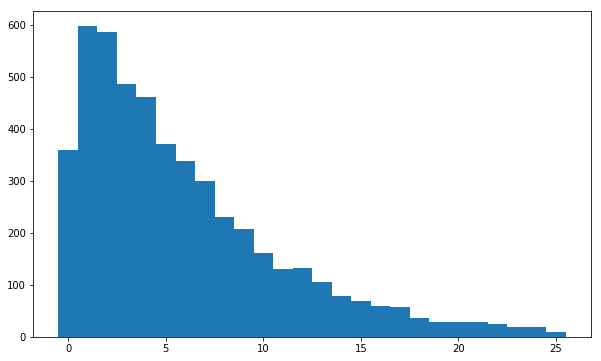

0.0967049532713


In [50]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (10, 6)

# 7% of users don't reorder anything
t = train.groupby('order_id').apply(lambda x: sum(x['reordered']))
n, bins, patches = plt.hist(t, bins=np.linspace(-0.5, 25.5, 27))
print n[0] / 1.0 / sum(n)
plt.show()

# only 10% of products are reordered
t = prior.groupby('user_id').apply(lambda x: len(set(x['product_id']))).sum()
s = train['reordered'].sum()
print s / 1.0 / t

In [26]:
export_graphviz(clf, out_file='tree.dot')